# Memory-Robust Risk Analysis

Much of the theory and practice of quantitative asset management is routed in implicitly or explicitly assuming that asset returns are i.i.d. Gaussian, despite well documented empirical evidence to the contrary. From the widespread use of linear regression and regularized versions thereof (e.g. LASSO, Ridge and Elastic-Net) in signal construction, to the use of Pearson's correlation to measure risk, to the use of CAPM's beta and alpha coefficients to measure market exposure and idiosyncratic expected return respectively, examples abound.

However, relaxing the i.i.d. Gaussian assumption could be a daunting undertaking to some quants, and academic models that do so might not necessarily be robust enough for production use. This is where the `kxy` package comes in.

In a previous tutorial, we illustrated how the `kxy` package can be used to estimate Pearson's correlation matrix assuming draws are i.i.d. but non-Gaussian. 

In this tutorial, we illustrate how the `kxy` package can be used to detect and robustly quantify *memory* in Gaussian time series.

Specifically, using the `kxy` package, we show that S&P 100 daily stock returns exhibit memory, stylized fact that goes against the i.i.d. assumption in linear risk models, but that is consistent with the longevity of the quantitative invesment management industry. We show that this memory is transient, which is consistent with the expectation that market inefficiencies tend to morph or disappear over time as market participant *arbitrage* them away. We provide analog of Pearson's correlation and CAPM's beta that factor-in temporal dependency.

##  I - The Data
We query daily prices for stocks in the S&P 100 from the unofficial Yahoo Finance API.

In [1]:
import os
from datetime import datetime

import numpy as np
import pandas as pd
import pylab as plt


import kxy
from yahooquery import Ticker
tickers = Ticker('aapl abbv abt acn adbe aig all amgn amt amzn axp '\
                 'ba bac biib bk bkng blk bmy brk-b c cat chtr cl '\
                 'cmcsa cof cop cost crm csco cvs cvx dd dhr dis '\
                 'dow duk emr exc f fb fdx gd ge gild gm goog googl '\
                 'gs hd hon ibm intc jnj jpm khc kmi ko lly lmt low '\
                 'ma mcd mdlz mdt met mmm mo mrk ms msft nee nflx '\
                 'nke nvda orcl oxy pep pfe pg pm pypl qcom rtx sbux '\
                 'slb so spg t tgt tmo txn unh unp ups usb v vz wba '\
                 'wfc wmt xom ^gspc')

In [2]:
prices_df = tickers.history(period='5y')

In [3]:
all_closes = prices_df['adjclose'].reset_index()
flat_closes = pd.concat([all_closes[all_closes['symbol'] == asset].rename(\
    columns={'adjclose': asset}).set_index(['date'])[[asset]]\
    for asset in list(set(all_closes['symbol'].values))], axis=1)
daily_returns = flat_closes.pct_change()
daily_returns_1y = daily_returns.loc[datetime(2019, 6, 1):datetime(2020, 6, 1)]
daily_returns_2y = daily_returns.loc[datetime(2018, 6, 1):datetime(2020, 6, 1)]
daily_returns_5y = daily_returns.loc[datetime(2015, 6, 1):datetime(2020, 6, 1)]

## II - Quantifying Memory

The qualitative question guiding any approach to measuring memory in time series is the following. Does knowing the past inform us about the future? Said differently, does knowing all past values until now reduce our uncertainty about the next value of the time series?

A candidate measure of the memory in a time series is therefore the uncertainty reduction about a future value of the time series that can be achieved by observing all past values, in the limit case of an infinite number of such past values. We call this the measure of auto-predictability of a time series:

$$\mathbb{PR}\left(\{x_t\} \right) := \lim_{T \to +\infty} h(x_T) - h\left(x_T \vert x_{T-1}, \dots \right).$$

When it exists, the measure of auto-predictability is always non-negative, and is zero if and only if all samples of the time series across time are mutually independent (i.e. the past is unrelated to the future, or the time series is memoryless).

In the case of stationary time series, $\mathbb{PR}(\{x_t\})$ always exists and is given by the difference between the entropy of any observation and the entropy rate of the time series:

$$\mathbb{PR}\left(\{x_t\} \right) := h\left(x_* \right) - h\left(\{x_t \} \right).$$

To estimate $\mathbb{PR}\left(\{x_t\} \right)$ we use the principle of maximum entropy, as usual, to find an appropriate diffusion for $\{x_t\}$. Example constraints that can capture temporal depedence are autocoviance constraints. 

When the first $p$ autocovariance terms are used as constraints to the maximum entropy in the primal/observation space, the optimial diffusion is the Gaussian (vector-)autoregressive process of order $p$ (i.e. the Gaussian (V)AR(p)) with the same autocovariance terms, and both $h\left(x_* \right)$ and $h\left(\{x_t \} \right)$ are available in closed-form.


As discussed in the previous tutorial, when distributions are jointly Gaussian, estimation of the Pearson autocovariance terms can be made robust to outliers by first estimating their Spearman counterparts, and then mapping them back using the Gaussian assumption. 

The method `kxy.auto_predictability` implements robust and non-robust primal maximum entropy estimation of the coefficient of auto-predictability under autocovariance constraints.

Noting that 

$$\mathbb{PR}\left(\{x_t\} \right) = h\left(u_* \right) - h\left(\{u_t \} \right) = \mathbb{PR}\left(\{ u_t \}\right),$$

where $u_t$ is the copula-uniform dual representation of $x_t$, it follows that the auto-predictability score does not in fact depend on marginals, and the maximum entropy problem could also be formulated and solved in the copula-uniform dual space.

In [4]:
aps = daily_returns_1y.kxy.auto_predictability()

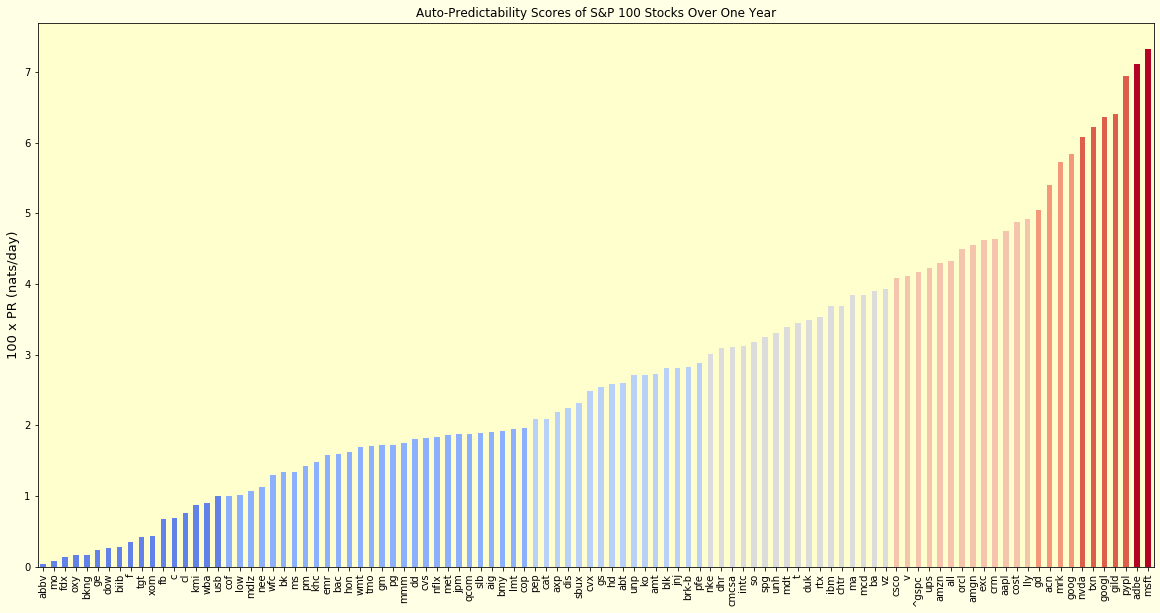

In [5]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
cmap = cm.get_cmap('coolwarm')
cmap_norm = Normalize(vmin=0, vmax=8)
fig, ax = plt.subplots(figsize=(20, 10))
for t in range(1, 9):
    (100.0*aps[np.logical_and(aps>=(t-1)/100., aps<t/100.)])\
    .plot(kind='bar', ax=ax, color=cmap(cmap_norm(t)))
ax.set_ylabel('100 x PR (nats/day)', fontsize=13)
ax.set_facecolor('yellow')
fig.patch.set_facecolor('yellow')
ax.patch.set_alpha(0.1)
fig.patch.set_alpha(0.1)
ax.legend().set_visible(False)
ax.set_title('Auto-Predictability Scores of S&P 100 Stocks Over One Year')
plt.show()

##  III - Beyond Pearson's Correlation Coefficient

In a previous post, we discussed the limitations of Pearson's correlation, as measure of risk, when asset returns are  non-Gaussian. 

Another limitation of Pearson's correlation is that it only captures cross-sectional risk, and fails to measure temporal risk. 

In practice, however, shocks can propagate in the market from one asset to another with some delay. Thus, cross-sectional risk would tend to underestimate the true association between asset returns.

We generalized the memoryless information-adjusted correlation previous introduced, 

$$\text{IA-}\mathbb{C}\text{orr}\left(x_*, y_* \right) = \text{sgn}\left(\mathbb{C}\text{orr}\left(x_*, y_* \right) \right)\sqrt{1-e^{-2I\left(x_*, y_* \right)}},$$

into a memoryful equivalent for stationary but not necessarily memoryless time series:

$$\text{IA-}\mathbb{C}\text{orr}\left(\{x_t\}, \{y_t\} \right) = \text{sgn}\left(\mathbb{C}\text{orr}\left(x_*, y_* \right) \right)\sqrt{1-e^{-2I\left(\{x_t\}, \{y_t\} \right)}},$$

where $I\left(\{x_t\}, \{y_t\} \right):= h\left( \{x_t\} \right) + h\left( \{y_t\} \right) - h\left( \{x_t, y_t\} \right) $ is the mutual information rate between the two stationary time series.

Note that when both time series are memoryless (i.e. $ \forall s \neq t, ~~ (x_t, y_t) \perp (x_s, y_s)$), we recover the memoryless version. 

In general, however, while the memoryless information-adjusted correlation is $0$ if and only if $x_t \perp y_t$ (i.e. there is no cross-sectional dependence), the memoryful information-adjusted correlation is $0$ if and only if $\{x_t\} \perp \{y_t\}$ (i.e. there is no cross-sectional or temporal association).

Information-adjusted correlation with primal maximum entropy estimation is implemented through the `robust-person` correlation estimation method. The variable `p` represents the number of autocovariance lags to use as maximum entropy constraints.

In [6]:
rps_corr_1   = daily_returns_1y.kxy.corr(method='robust-pearson', p=0)
rps_corr_1o  = daily_returns_1y.kxy.corr(method='robust-pearson', p=None)

To illustrate the effect of memory on information-adjusted correlation, we plot the memoryless information-adjusted correlation against the memoryful information-adjusted correlation for daily returns of S&P 100 stocks over a year.

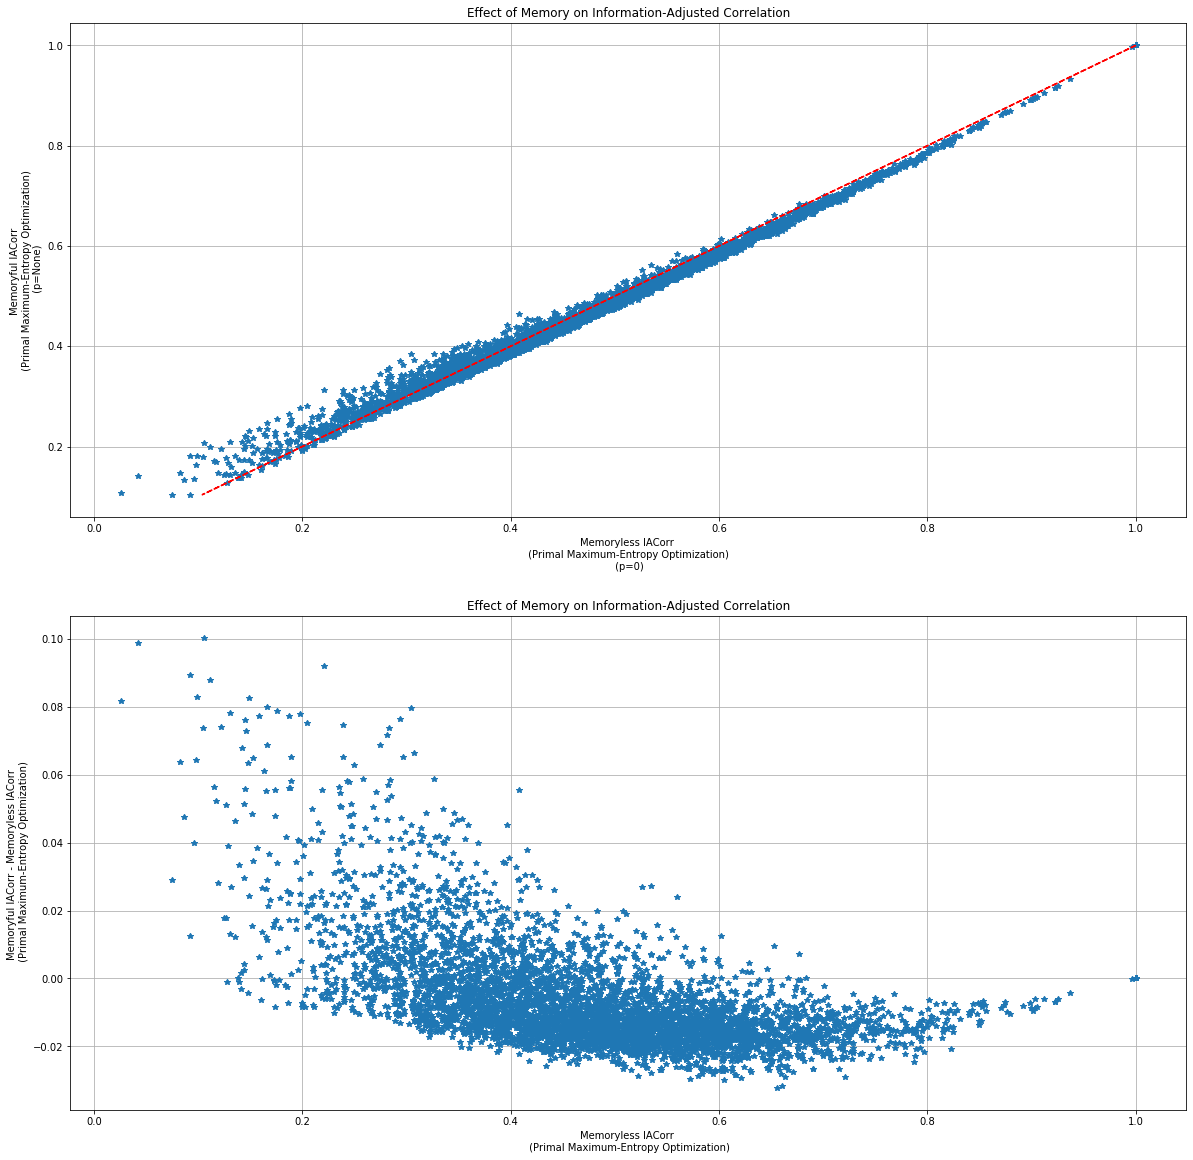

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(20, 20))
ax[0].plot(rps_corr_1.values.flatten(), rps_corr_1o.values.flatten(), '*')
ax[0].plot(rps_corr_1o.values.flatten(), rps_corr_1o.values.flatten(), \
              '--', label='y=x', c='r')
ax[0].set_ylabel('Memoryful IACorr \n '
              '(Primal Maximum-Entropy Optimization) \n (p=None)', \
                 fontsize=10)
ax[0].set_xlabel('Memoryless IACorr \n '
              '(Primal Maximum-Entropy Optimization) \n (p=0)', \
                 fontsize=10)
ax[0].set_title('Effect of Memory on Information-Adjusted Correlation')
ax[0].grid()
ax[1].plot(rps_corr_1.values.flatten(), rps_corr_1o.values.flatten()\
           -rps_corr_1.values.flatten(), '*')
ax[1].set_ylabel('Memoryful IACorr - Memoryless IACorr \n '
              '(Primal Maximum-Entropy Optimization)', \
                 fontsize=10)
ax[1].set_xlabel('Memoryless IACorr \n '
              '(Primal Maximum-Entropy Optimization)', \
                 fontsize=10)
ax[1].set_title('Effect of Memory on Information-Adjusted Correlation')
ax[1].grid()

There are two main takeaways:

* When the memoryless correlation is very high, the memoryful correlation tends to be lower. This could mean that strong cross-sectional co-movements tend to be followed by market corrections that are less strongly related and more idiosyncratic.
* When the memoryful correlation is small, the memoryful correlation tends to be higher. A plausible interpretation for this is that stocks that do not exhibit strong cross-sectional associations might nonetheless have similar trends.



## IV - Effects of The Number of Autocovariance Lags & Time Horizon

Next, we look at the effect of the number of consecutive autocovariance constraints $p$ and the time range $T$ on evidence of memory. Intuitively, we would expect that the higher $p$, the stronger the evidence of memory we would see. 

Similarly, the larger the time horizon used, the more time market participants will have to exploit the associated market inefficiencies, and the less evidence of memory we would see in historical data.

In [8]:
rps_corr_2  = daily_returns_2y.kxy.corr(method='robust-pearson', p=0)
rps_corr_5  = daily_returns_5y.kxy.corr(method='robust-pearson', p=0)

rps_corr_11  = daily_returns_1y.kxy.corr(method='robust-pearson', p=1)
rps_corr_15  = daily_returns_1y.kxy.corr(method='robust-pearson', p=5)
rps_corr_110 = daily_returns_1y.kxy.corr(method='robust-pearson', p=10)

rps_corr_2o  = daily_returns_2y.kxy.corr(method='robust-pearson', p=None)
rps_corr_21  = daily_returns_2y.kxy.corr(method='robust-pearson', p=1)
rps_corr_25  = daily_returns_2y.kxy.corr(method='robust-pearson', p=5)
rps_corr_210 = daily_returns_2y.kxy.corr(method='robust-pearson', p=10)

rps_corr_5o  = daily_returns_5y.kxy.corr(method='robust-pearson', p=None)
rps_corr_51  = daily_returns_5y.kxy.corr(method='robust-pearson', p=1)
rps_corr_55  = daily_returns_5y.kxy.corr(method='robust-pearson', p=5)
rps_corr_510 = daily_returns_5y.kxy.corr(method='robust-pearson', p=10)

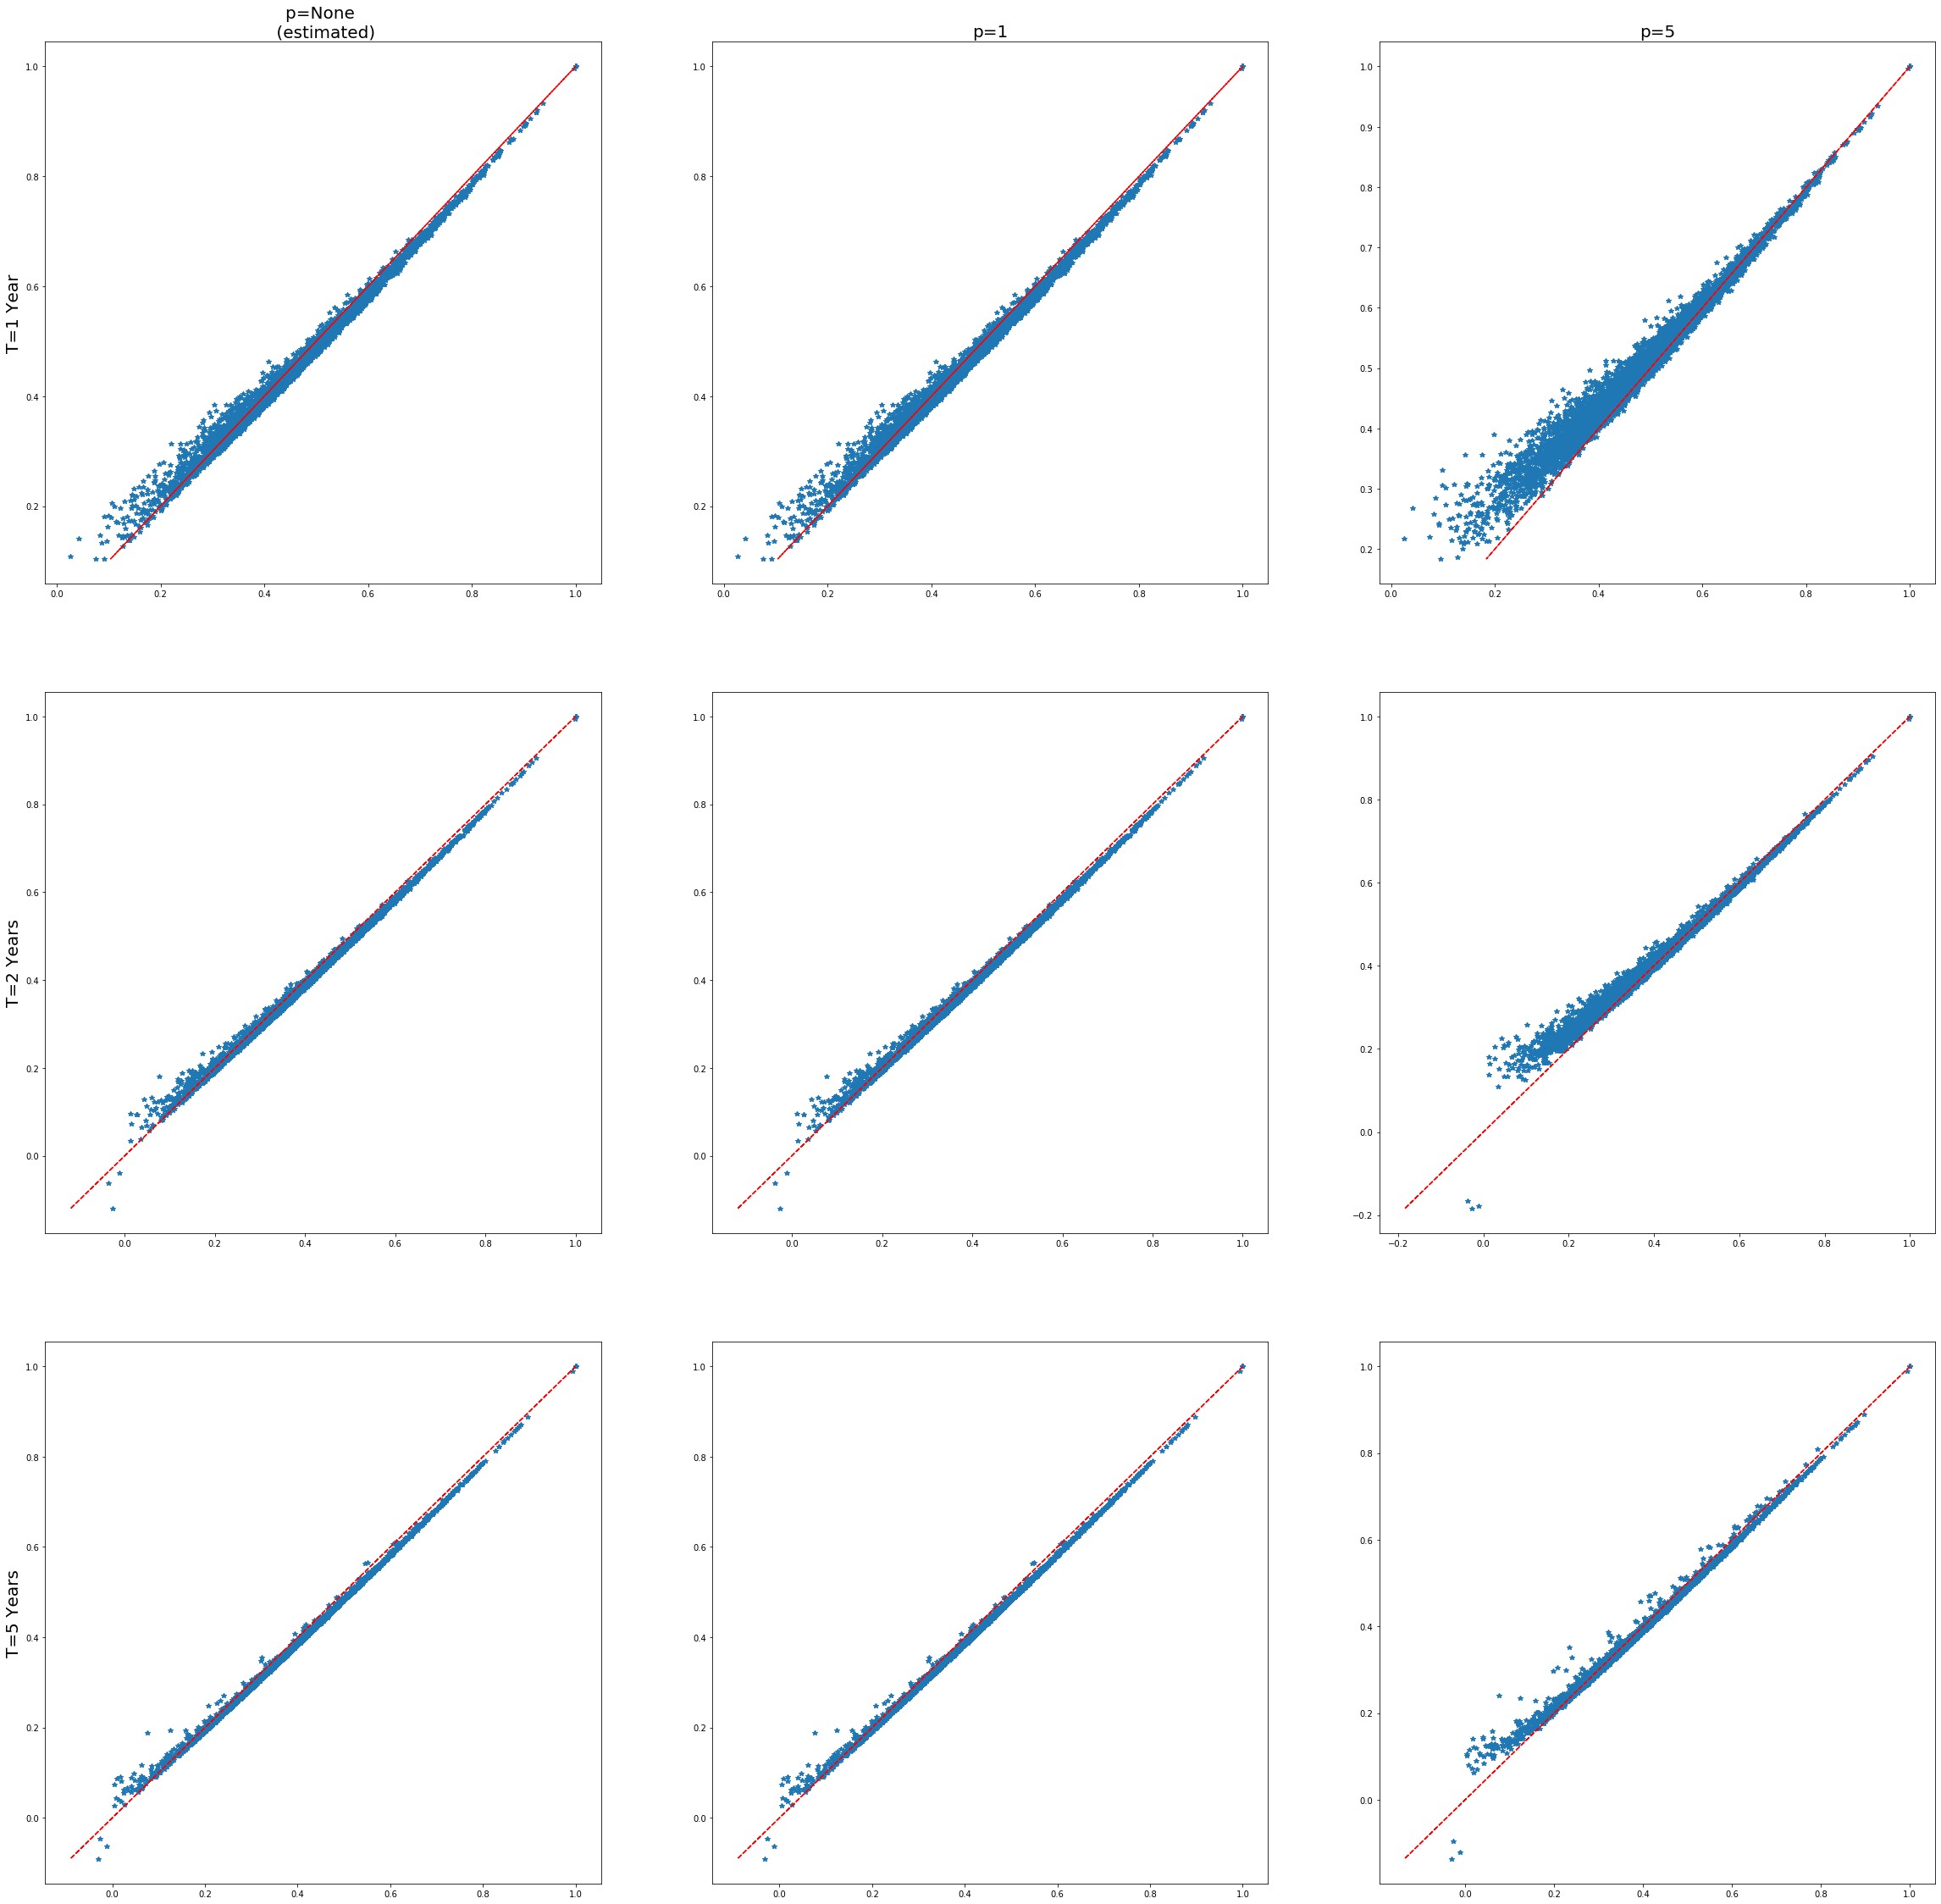

In [9]:
fig, ax = plt.subplots(3, 3, figsize=(40, 40))
ax[0, 0].set_title('p=None \n (estimated)', fontsize=20)
ax[0, 0].set_ylabel('T=1 Year', fontsize=20)
ax[0, 0].plot(rps_corr_1.values.flatten(), rps_corr_1o.values.flatten(), '*')
ax[0, 0].plot(rps_corr_1o.values.flatten(), rps_corr_1o.values.flatten(), \
              '--', label='y=x', c='r')
ax[1, 0].set_ylabel('T=2 Years', fontsize=20)
ax[1, 0].plot(rps_corr_2.values.flatten(), rps_corr_2o.values.flatten(), '*')
ax[1, 0].plot(rps_corr_2o.values.flatten(), rps_corr_2o.values.flatten(), \
              '--', label='y=x', c='r')
ax[2, 0].set_ylabel('T=5 Years', fontsize=20)
ax[2, 0].plot(rps_corr_5.values.flatten(), rps_corr_5o.values.flatten(), '*')
ax[2, 0].plot(rps_corr_5o.values.flatten(), rps_corr_5o.values.flatten(), \
              '--', label='y=x', c='r')

ax[0, 1].set_title('p=1', fontsize=20)
ax[0, 1].plot(rps_corr_1.values.flatten(), rps_corr_11.values.flatten(), '*')
ax[0, 1].plot(rps_corr_11.values.flatten(), rps_corr_11.values.flatten(), \
              '--', label='y=x', c='r')
ax[1, 1].plot(rps_corr_2.values.flatten(), rps_corr_21.values.flatten(), '*')
ax[1, 1].plot(rps_corr_21.values.flatten(), rps_corr_21.values.flatten(), \
              '--', label='y=x', c='r')
ax[2, 1].plot(rps_corr_5.values.flatten(), rps_corr_51.values.flatten(), '*')
ax[2, 1].plot(rps_corr_51.values.flatten(), rps_corr_51.values.flatten(), \
              '--', label='y=x', c='r')

ax[0, 2].set_title('p=5', fontsize=20)
ax[0, 2].plot(rps_corr_1.values.flatten(), rps_corr_15.values.flatten(), '*')
ax[0, 2].plot(rps_corr_15.values.flatten(), rps_corr_15.values.flatten(), \
              '--', label='y=x', c='r')
ax[1, 2].plot(rps_corr_2.values.flatten(), rps_corr_25.values.flatten(), '*')
ax[1, 2].plot(rps_corr_25.values.flatten(), rps_corr_25.values.flatten(), \
              '--', label='y=x', c='r')
ax[2, 2].plot(rps_corr_5.values.flatten(), rps_corr_55.values.flatten(), '*')
ax[2, 2].plot(rps_corr_55.values.flatten(), rps_corr_55.values.flatten(), \
              '--', label='y=x', c='r')
plt.show()

Both intuitions are confirmed empirically. 

##  V - Beyond CAPM's $\beta$

We generalize beta $\beta := \mathbb{C}\text{orr}\left(r, r_m\right) \sqrt{\frac{\mathbb{V}\text{ar}(r)}{\mathbb{V}\text{ar}(r_m)}}$ into the information-adjusted beta by replacing Pearson's correlation with the (memoryful) information-adjusted correlation.

In [10]:
# Beta of S&P 100 stocks relative to the S&P 500 index
betas = pd.concat([daily_returns_1y.kxy.beta('^gspc', method='information-adjusted')\
               .rename(columns={'beta': 'Information-Adjusted (Dual, Memoryless)'}),\
               daily_returns_1y.kxy.beta('^gspc', method='robust-pearson', p=0)\
               .rename(columns={'beta': 'Information-Adjusted (Primal, Memoryless)'}),\
               daily_returns_1y.kxy.beta('^gspc', method='robust-pearson', p=None)\
               .rename(columns={'beta': 'Information-Adjusted (Primal, Memoryful)'}),\
               daily_returns_1y.kxy.beta('^gspc', method='pearson')\
               .rename(columns={'beta': 'Standard Pearson'})], axis=1)

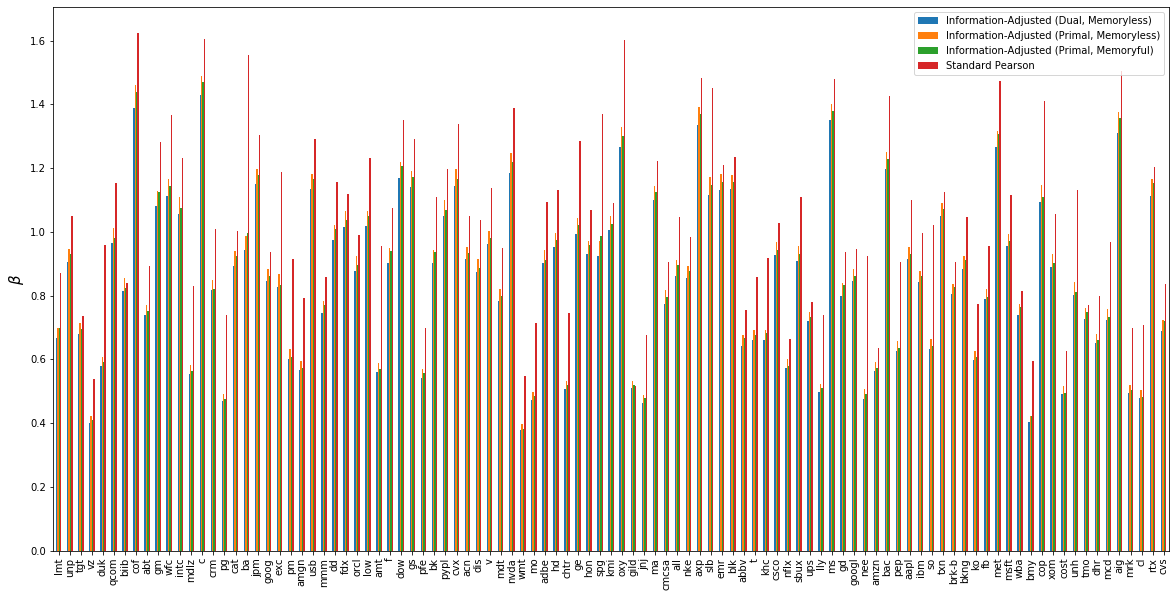

In [11]:
fig, ax = plt.subplots(figsize=(20, 10))
betas.plot.bar(ax=ax)
ax.set_ylabel(r'''$\beta$''', fontsize=15)
plt.show()

##  V - Final Thoughts

Over a long enough time horizon, memory in daily asset returns is negligible. However, in the short run, quantifying memory in asset returns can play a critical role, not just in building alpha models, but in better understanding and modeling portfolio risk.

The `kxy` package empowers quants to quantify the effect of memory in their portfolio risk, from the comfort of Python and pandas.